### Data Preprocessing ##

- read location, accelerometer and heart rate data files
- resample by second
- get PID #9 data, output to file

In [117]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_folder = "/Users/Fyxstkala/Documents/GitHub/mhealth_sensing/data/" # ROOT FOLDER CHANGE THIS

hr_file = data_folder + "Smartwatch_HeartRateDatum.csv"
acc_file = data_folder + "Sensus_Accelerometer.csv"
loc_file = data_folder + "Sensus_Location.csv"
hr_out_file = data_folder + "hr_data.csv"
acc_out_file = data_folder + "acc_data.csv"
loc_out_file = data_folder + "loc_data.csv"
combined_file = data_folder + "combined_data_outer.csv"
preprocessed_file = data_folder + "preprocessed.csv"

In [ ]:
# Process HR File

for chunk in pd.read_csv(hr_file, header = 0, chunksize=10**6):
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'],
                                    origin="unix", 
                                    errors="coerce")
    chunk = chunk[["participantid","HR","Timestamp"]]
    chunk.columns =["PID","HR","Timestamp"] # reset column name
    chunk[['HR','PID']]=  chunk[['HR','PID']].apply(pd.to_numeric,
                                                    errors='coerce', downcast = "float") # change variable type
    chunk.set_index(['Timestamp'], inplace=True) # set timestamp as index 
    chunk = chunk.resample("S").mean().reset_index() # resample by second
    print(chunk.shape)
    chunk = chunk.loc[chunk['PID'] == 9.0]
    with open(hr_out_file, 'a') as f:
        chunk.to_csv(f, header=False)

In [ ]:
# Process Accelerometer File

for chunk in pd.read_csv(acc_file, header = 0, chunksize=10**6):
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'],
                                    origin="unix", 
                                    errors="coerce")
    chunk = chunk[["ParticipantId","X","Y","Z","Timestamp"]]
    chunk.columns = ["PID","X","Y","Z","Timestamp"] # reset column name
    chunk[['PID','X','Y','Z']] = chunk[['PID','X','Y','Z']].apply(pd.to_numeric,
                                                errors='coerce', downcast = "float") # change var type
    chunk.set_index(['Timestamp'], inplace=True) # set timestamp as index 
    chunk = chunk.resample("S").mean().reset_index() # resample by second
    print(chunk.shape)
    chunk = chunk.loc[chunk['PID'] == 9.0]
    with open(acc_out_file, 'a') as f:
        chunk.to_csv(f, header=False)

In [ ]:
# Process Location File

for chunk in pd.read_csv(loc_file, header = 0, chunksize=10**6):
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'],
                                    origin="unix", 
                                    errors="coerce")
    chunk = chunk[["ParticipantId","Latitude","Longitude","Timestamp"]]
    chunk.columns =["PID","Latitude","Longitude","Timestamp"] # reset column name
    # change variable type
    chunk[['Latitude','Longitude','PID']]=  chunk[['Latitude','Longitude','PID']].apply(pd.to_numeric, 
                                                                                        errors='coerce', 
                                                                                        downcast = "float") 
    chunk.set_index(['Timestamp'], inplace=True) # set timestamp as index 
    chunk = chunk.resample("S").mean().reset_index() # resample by second
    print(chunk.shape)
    chunk = chunk.loc[chunk['PID'] == 9.0]
    with open(loc_out_file, 'a') as f:
        chunk.to_csv(f, header=False)

### Aggregating Files

- aggregate all three files to one (keep NaN)

In [58]:
def set_datetime(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'],
                                     origin="unix",
                                     errors="coerce")
    return df

In [59]:
hr_df = pd.read_csv(hr_out_file, header = None)
hr_df.columns = ["index","Timestamp","PID","HR"]
hr_df = set_datetime(hr_df)
print(hr_df.shape)

(313598, 4)


In [60]:
acc_df = pd.read_csv(acc_out_file, header = None)
acc_df.columns = ["index","Timestamp","PID","X","Y","Z"]
acc_df = set_datetime(acc_df)
print(acc_df.shape)

(23016115, 6)


In [61]:
loc_df = pd.read_csv(loc_out_file, header = None)
loc_df.columns = ["index","Timestamp","PID","Latitude","Longitude"]
loc_df = set_datetime(loc_df)
print(loc_df.shape)

(1375778, 5)


In [62]:
print(hr_df[:5])
print(loc_df[:5])
print(acc_df[:5])


      index           Timestamp  PID     HR
0  28200976 2018-11-02 00:26:39  9.0  115.0
1  28205935 2018-11-02 01:49:18  9.0  102.0
2  28205986 2018-11-02 01:50:09  9.0  108.0
3  28205995 2018-11-02 01:50:18  9.0  107.5
4  28206373 2018-11-02 01:56:36  9.0   91.0
    index           Timestamp  PID   Latitude  Longitude
0   72820 2018-11-02 15:15:07  9.0  38.030903 -78.510900
1   86228 2018-11-02 18:58:35  9.0  38.030674 -78.505630
2  262258 2018-11-04 19:52:25  9.0  38.057487 -78.501270
3  262485 2018-11-04 19:56:12  9.0  38.057484 -78.501250
4  263118 2018-11-04 20:06:45  9.0  38.049034 -78.508675
   index           Timestamp  PID         X         Y         Z
0   8826 2018-11-01 22:25:48  9.0  0.015261 -0.005453 -0.988026
1   8827 2018-11-01 22:25:49  9.0  0.014712 -0.005540 -0.988052
2   8828 2018-11-01 22:25:50  9.0  0.015244 -0.005294 -0.987978
3   8829 2018-11-01 22:25:51  9.0  0.015270 -0.005137 -0.988068
4   8830 2018-11-01 22:25:52  9.0  0.014770 -0.005396 -0.988174


In [68]:
hr_acc_df = pd.merge(hr_df, acc_df, how="outer", on="Timestamp")
print(hr_acc_df.shape)

(23172085, 9)


In [69]:
combined_df = pd.merge(hr_acc_df, loc_df, how="outer", on="Timestamp")
print(combined_df.shape)

(200875551, 13)


In [71]:
combined_df = combined_df.drop(columns=['index_x','index_y','index','PID_x','PID_y'])
print(combined_df.shape)
combined_df = combined_df.drop_duplicates()
print(combined_df.shape)
print(combined_df[:5])

(200875551, 8)
(536982, 8)
               Timestamp     HR         X         Y         Z  PID   Latitude  \
0    2018-11-02 00:26:39  115.0       NaN       NaN       NaN  NaN        NaN   
1    2018-11-02 01:49:18  102.0  0.100423 -0.564653 -0.796036  9.0  38.008865   
404  2018-11-02 01:50:09  108.0  0.059478 -1.005974  0.237641  9.0  38.014576   
807  2018-11-02 01:50:18  107.5  0.060751 -0.670354 -0.669088  9.0  38.015583   
1210 2018-11-02 01:56:36   91.0 -0.100375  0.973441  0.210622  9.0  38.018010   

      Longitude  
0           NaN  
1    -78.527040  
404  -78.525856  
807  -78.525020  
1210 -78.521300  


In [73]:
combined_df.to_csv(combined_file, index = False)

### Features Extraction

In [107]:
df = pd.read_csv(combined_file, header = 0)
print(df.shape)

(536982, 8)


#### Get Time of Day
* Morning: 7AM - 11AM (0)
* Noon: 11AM-2PM (1)
* Afternoon: 2PM - 5PM (2)
* Evening: 5PM - 8PM (3)
* Night: 8PM - 11PM (4)

In [108]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'],
                                origin="unix", 
                                errors="coerce")
#df.set_index(['Timestamp'], inplace=True) 

In [109]:
def between_time(check, begin, end):
    if begin < end:
        return check >= begin and check <= end
    else:
        check >= begin or check <= end

def check_time_of_day(x):
    if between_time(x.time(),
                    dt.time(hour=7,minute=0,second=0),
                    dt.time(hour=11,minute=0,second=0)):
        return 1 # morning
    elif between_time(x.time(),
                    dt.time(hour=11,minute=0,second=0),
                    dt.time(hour=14,minute=0,second=0)):
        return 2 # noon
    elif between_time(x.time(),
                dt.time(hour=14,minute=0,second=0),
                dt.time(hour=17,minute=0,second=0)):
        return 3 # afternoon
    elif between_time(x.time(),
                dt.time(hour=17,minute=0,second=0),
                dt.time(hour=20,minute=0,second=0)):
        return 4 # evening-early night
    elif between_time(x.time(),
                dt.time(hour=20,minute=0,second=0),
                dt.time(hour=23,minute=0,second=0)):
        return 5 # night
    else:
        return 0 # other


In [110]:
df['time_of_day'] = df['Timestamp'].apply(lambda x: check_time_of_day(x))
print(df.loc[df['time_of_day']==0].shape)
df.head()

(192974, 9)


,Timestamp,HR,X,Y,Z,PID,Latitude,Longitude,time_of_day
0,2018-11-02 00:26:39,115.0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2018-11-02 01:49:18,102.0,0.100423,-0.564653,-0.796036,9.0,38.008865,-78.527040,0
2,2018-11-02 01:50:09,108.0,0.059478,-1.005974,0.237641,9.0,38.014576,-78.525856,0
3,2018-11-02 01:50:18,107.5,0.060751,-0.670354,-0.669088,9.0,38.015583,-78.525020,0
4,2018-11-02 01:56:36,91.0,-0.100375,0.973441,0.210622,9.0,38.018010,-78.521300,0


#### Get Magnitude Bins

* -inf ~ 0.985
* 0.985 ~ 0.99
* 0.99 ~ 1.0
* 1.0 ~ inf

In [111]:
# Acc Magnitutde
df['acc_mag'] = np.sqrt(df['X']**2 + df['Y']**2 + df['Z']**2)
df.head()

,Timestamp,HR,X,Y,Z,PID,Latitude,Longitude,time_of_day,acc_mag
0,2018-11-02 00:26:39,115.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,2018-11-02 01:49:18,102.0,0.100423,-0.564653,-0.796036,9.0,38.008865,-78.527040,0,0.981117
2,2018-11-02 01:50:09,108.0,0.059478,-1.005974,0.237641,9.0,38.014576,-78.525856,0,1.035372
3,2018-11-02 01:50:18,107.5,0.060751,-0.670354,-0.669088,9.0,38.015583,-78.525020,0,0.949076
4,2018-11-02 01:56:36,91.0,-0.100375,0.973441,0.210622,9.0,38.018010,-78.521300,0,1.001012


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x140c39c18>]],
      dtype=object)

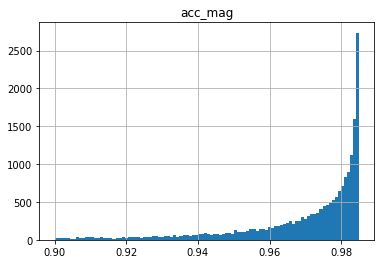

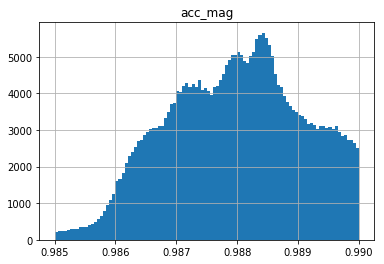

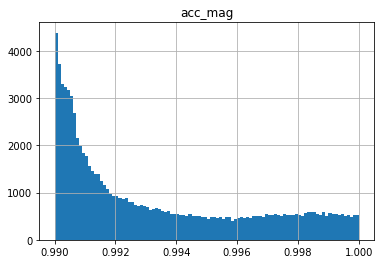

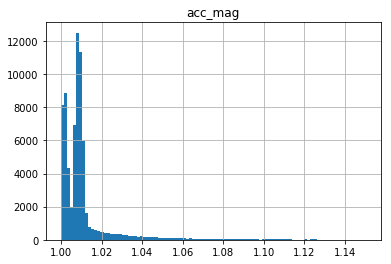

In [112]:
df.hist(column = 'acc_mag', range = (0.9, 0.985), bins = 100)
df.hist(column = 'acc_mag', range = (0.985, 0.99), bins = 100)
df.hist(column = 'acc_mag', range = (0.99, 1.0), bins = 100)
df.hist(column = 'acc_mag', range = (1.0, 1.15), bins = 100)

In [113]:
def check_magnitude(x):
    if x < 0.985:
        return 1
    if x >= 0.985 and x < 0.99:
        return 2
    if x >= 0.99 and x < 1.0:
        return 3
    if x >= 1.0:
        return 4

In [114]:
df['magnitude'] = df['acc_mag'].apply(lambda x: check_magnitude(x))
df.head()

,Timestamp,HR,X,Y,Z,PID,Latitude,Longitude,time_of_day,acc_mag,magnitude
0,2018-11-02 00:26:39,115.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,2018-11-02 01:49:18,102.0,0.100423,-0.564653,-0.796036,9.0,38.008865,-78.527040,0,0.981117,1.0
2,2018-11-02 01:50:09,108.0,0.059478,-1.005974,0.237641,9.0,38.014576,-78.525856,0,1.035372,4.0
3,2018-11-02 01:50:18,107.5,0.060751,-0.670354,-0.669088,9.0,38.015583,-78.525020,0,0.949076,1.0
4,2018-11-02 01:56:36,91.0,-0.100375,0.973441,0.210622,9.0,38.018010,-78.521300,0,1.001012,4.0


In [116]:
df.to_csv(preprocessed_file, index=False)